In [1]:
import torch
import numpy as np
import pandas as pd
import cv2
import segmentation_models_pytorch as smp


import albumentations
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/workspace/src/seg_loss/')

In [3]:
from lovasz_losses import SymmetricLovaszLoss

In [4]:
df = pd.read_csv('/data/df_train2.csv')

In [5]:
df.shape

(30083, 16)

In [6]:
6000 * 32

192000

In [5]:
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    activation=None
)

In [6]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [7]:
# inp = torch.rand(4, 1, 512, 512)
# out = torch.rand(4, 1, 512, 512)

inp = np.random.rand(4, 1, 512, 512)
out = np.random.rand(4, 1, 512, 512)

In [8]:
inp_tensor = torch.tensor(inp, dtype=torch.float).cuda()
out_tensor = torch.tensor(out, dtype=torch.float).cuda()
model = model.cuda()

In [9]:
pred = model(inp_tensor)

In [10]:
pred.shape

torch.Size([4, 1, 512, 512])

In [11]:
criterion = SymmetricLovaszLoss()

In [12]:
loss = criterion(pred, out_tensor, 0)

In [13]:
loss

tensor(1.1861, device='cuda:0', grad_fn=<DivBackward0>)

In [14]:
loss = criterion(pred, out_tensor, 0)

In [25]:
class RanzcrSegDataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 image_folder=None,
                 from_image_folder=False,
                 transform=None,
                 mode="train",
                 clahe=False,
                 mix=False,
                 ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.image_folder = image_folder
        self.from_image_folder = from_image_folder
        self.transform = transform

        self.mode = mode
        self.clahe = clahe
        self.mix = mix
        if self.clahe or self.mix:
            self.clahe_transform = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(16, 16))

        self.cols = [
            'ETT - Abnormal', 'ETT - Borderline',
            'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
            'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
            'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present'
                     ]

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]

        if self.from_image_folder:
            img_path = os.path.join(self.image_folder, row["StudyInstanceUID"] + ".jpg")
        else:
            img_path = row.img_path
        images = cv2.imread(img_path).astype(np.float32)
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread('/data/additional/train_lung_masks/train_lung_masks/'+row.StudyInstanceUID+'.jpg',
                          cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (images.shape[1], images.shape[0]))
        mask = (mask > 127) * 1


        if self.clahe:
            single_channel = images[:, :, 0].astype(np.uint8)
            single_channel = self.clahe_transform.apply(single_channel)
            images = np.array([
                single_channel,
                single_channel,
                single_channel
            ]).transpose(1, 2, 0)
        elif self.mix:
            single_channel = images[:, :, 0].astype(np.uint8)
            clahe_channel = self.clahe_transform.apply(single_channel)
            hist_channel = cv2.equalizeHist(single_channel)
            images = np.array([
                single_channel,
                clahe_channel,
                hist_channel
            ]).transpose(1, 2, 0)

        if self.transform is not None:
            transformed = self.transform(image=images.astype(np.uint8), mask=mask.astype(np.uint8))
            images = transformed['image']
            mask = transformed['mask']
        else:
            images = images.transpose(2, 0, 1)

        # normalize image
        # images = images / 255
        # image net normalize
        # images = (images - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])

        if self.mode == "train":
#             label = row[self.cols].values.astype(np.float16)
            return {
                # "image": torch.tensor(images, dtype=torch.float),
                "image": images,
                "target": mask
            }
        else:
            return {
                "image": torch.tensor(images, dtype=torch.float)
            }


In [26]:
def get_train_transforms(image_size):
    return albumentations.Compose([
           albumentations.ShiftScaleRotate(shift_limit=0.05, scale_limit=0., rotate_limit=30, p=0.8),
           albumentations.RandomResizedCrop(image_size, image_size, scale=(0.7, 1), p=0.5),
           albumentations.HorizontalFlip(p=0.5),
           albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.7),
           albumentations.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.7),
           albumentations.CLAHE(clip_limit=(1, 4), p=0.5),
           # albumentations.OneOf([
           #     albumentations.OpticalDistortion(distort_limit=1.0),
           #     albumentations.GridDistortion(num_steps=5, distort_limit=1.),
           #     albumentations.ElasticTransform(alpha=3),
           # ], p=0.2),
           albumentations.OneOf([
               albumentations.GaussNoise(var_limit=[10, 50]),
               albumentations.GaussianBlur(),
               albumentations.MotionBlur(),
               albumentations.MedianBlur(),
           ], p=0.2),
          albumentations.Resize(image_size, image_size),
          # albumentations.OneOf([
          #     albumentations.augmentations.transforms.JpegCompression(),
          #     albumentations.augmentations.transforms.Downscale(scale_min=0.1, scale_max=0.15),
          # ], p=0.2),
          # albumentations.imgaug.transforms.IAAPiecewiseAffine(p=0.2),
          # albumentations.imgaug.transforms.IAASharpen(p=0.2),
          albumentations.Cutout(max_h_size=int(image_size * 0.1), max_w_size=int(image_size * 0.1), num_holes=5, p=0.5),
          albumentations.Normalize(
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225],
          ),
          ToTensorV2(p=1)
])

In [27]:
transform = get_train_transforms(512)

In [28]:
dataset = RanzcrSegDataset(df=df, image_size=512, image_folder="/data/train1280", transform=transform)

In [29]:
data = dataset[0]

In [30]:
data['target'].shape

torch.Size([512, 512])

In [31]:
data['image'].shape

torch.Size([3, 512, 512])

In [32]:
def plot_img_mask(data):
    img = data['image'].numpy().transpose(1, 2, 0)
    mask = data['target'].numpy()
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(mask*255)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


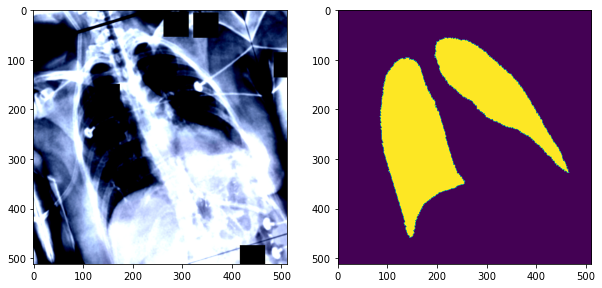

In [33]:
plot_img_mask(data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


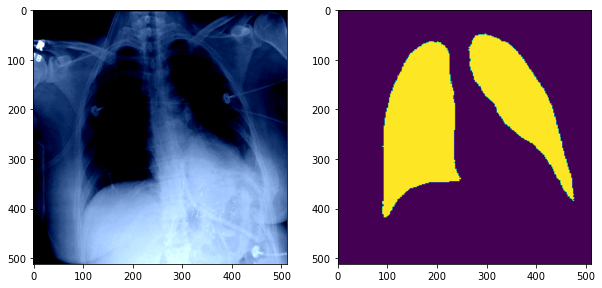

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


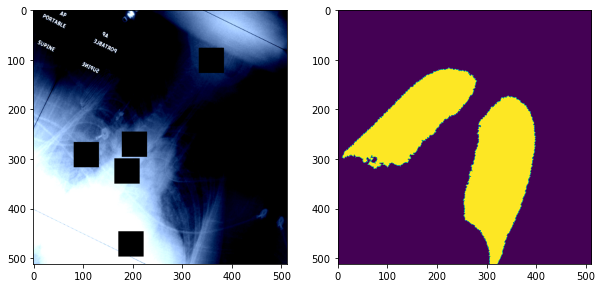

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


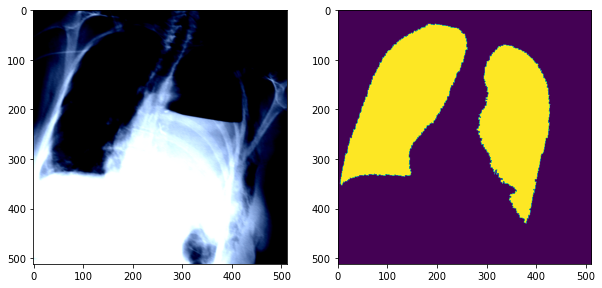

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


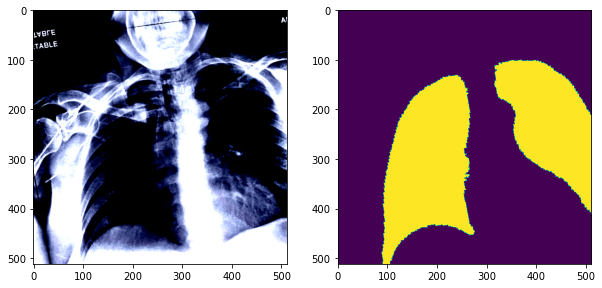

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


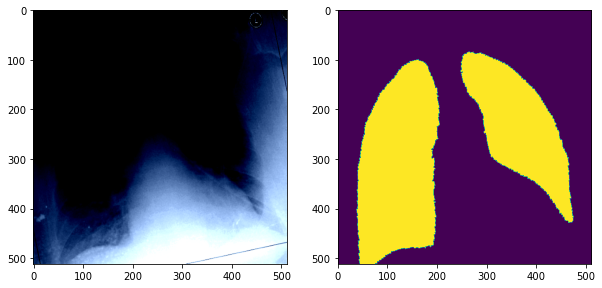

In [34]:
for i in range(5):
    plot_img_mask(dataset[i])